In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

%matplotlib inline
%load_ext google.cloud.bigquery

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Authenticated


In [4]:
project_id = 'ethereum-326902'
client = bigquery.Client(project=project_id)

In [5]:
tables = ["blocks", "transactions", "tokens", "logs", 
          "traces", "contracts", "balances", "token_transfers"]
#tables = {i : f"`etherium-liquidity.crypto_etherium.{i}`" for i in tables}
tables = {i : f"`bigquery-public-data.crypto_ethereum.{i}`" for i in tables}

In [6]:
tables

{'balances': '`bigquery-public-data.crypto_ethereum.balances`',
 'blocks': '`bigquery-public-data.crypto_ethereum.blocks`',
 'contracts': '`bigquery-public-data.crypto_ethereum.contracts`',
 'logs': '`bigquery-public-data.crypto_ethereum.logs`',
 'token_transfers': '`bigquery-public-data.crypto_ethereum.token_transfers`',
 'tokens': '`bigquery-public-data.crypto_ethereum.tokens`',
 'traces': '`bigquery-public-data.crypto_ethereum.traces`',
 'transactions': '`bigquery-public-data.crypto_ethereum.transactions`'}

In [7]:
limit = 1000

data = {
    k : client.query(
        f"SELECT * FROM {v} ORDER BY RAND() LIMIT {limit}"
        ).to_dataframe() for k, v in tqdm(tables.items())
    }

  0%|          | 0/8 [00:00<?, ?it/s]

Forbidden: ignored

## Blocks

In [ ]:
blocks = data['blocks']

In [ ]:
len(blocks['timestamp']) == len(blocks['timestamp'].unique()) ## timestamps are unique

In [ ]:
blocks = blocks.set_index('timestamp')

In [ ]:
numeric_fields = [
    'number',
    'difficulty',
    'total_difficulty', 
    'size',
    'gas_used',
    'gas_limit',
    'transaction_count',
    'base_fee_per_gas'
]
len(numeric_fields)

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

for i, f in enumerate(numeric_fields):
  row = int(np.floor(i / 2))
  col = i % 2
  pd.to_numeric(blocks[f]).plot(title=f, ax=axes[row, col])

fig.tight_layout();

Notes
- total difficulty =? difficulty up to that point
- difficulty rising exponentially
- gas used frequently reaches the limit
- what is base_fee_per_gas?
- transaction counts have stayed fairly static, size has risen

---



In [ ]:
### Question: what is base_fee_per_gas?
blocks['base_fee_per_gas'].dropna().index.min()

Timestamp('2021-08-07 16:40:03+0000', tz='UTC')

**London Upgrade & Base Fees**

In Aug '21 there was a change to make gas fees more predictable. 

Previously -
* gas fee = Gas units (limit) * Gas price per unit

Now it is - 
* gas fee = Gas units (limit) * (Base fee + Tip)

Benefits of the London upgrade
* better transaction fee estimation
* generally quicker transaction inclusion
* offsetting the ETH issuance by burning a percentage of transaction fees

Starting with the London network upgrade, every block has a base fee, the minimum price per unit of gas for inclusion in this block, calculated by the network based on demand for block space. As the base fee of the transaction fee is burnt, users are also expected to set a tip (priority fee) in their transactions. The tip compensates miners for executing and propagating user transactions in blocks and is expected to be set automatically by most wallets.

There are other changes with the London Upgrade - 
* block size
* MaxFeePerGas (in transactions dataset)

More questions
- Do you still pay gas if you reach the limit (yes)

In [ ]:
### Question: does total difficulty = sum of difficulty? Yes!

difficulty_df = client.query(
    f"SELECT timestamp, difficulty, total_difficulty FROM {tables['blocks']} ORDER BY timestamp ASC LIMIT 1000"
    ).to_dataframe() 

In [ ]:
diff = difficulty_df['total_difficulty'] - difficulty_df['difficulty'].cumsum() 
diff.sum() == 0

True

NameError: ignored

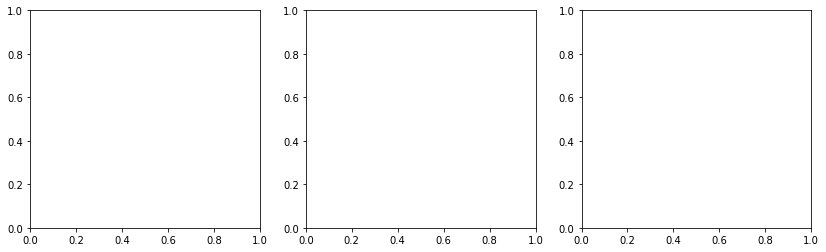

In [ ]:
### Questions: how often does gas_used reach gas_limit?

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

leftover = (blocks['gas_limit'] - blocks['gas_used']) / blocks['gas_limit']
leftover.plot(title="Gas Used % of Gas Limit", ax=axes[0]);

bins = 1000
df = pd.Series({i / bins : (leftover <= i / bins).mean() for i in range(bins)})
df.plot(title="% of Time less than x% Gas Leftover", ax=axes[1])
leftover.hist(ax=axes[2]);

df.head()

On the block level, gas tends to get very close to the limit. For 50% of the time the difference between gas_used and gas_limit is < 1%. 


In [ ]:
df = blocks['difficulty'] / blocks['total_difficulty'] - 1
pd.to_numeric(df)['2020':].plot()

NameError: ignored

In [ ]:
plt.scatter(
    x=blocks['difficulty'], 
    y=blocks['total_difficulty']
)
plt.title("difficulty vs total_difficulty");

NameError: ignored

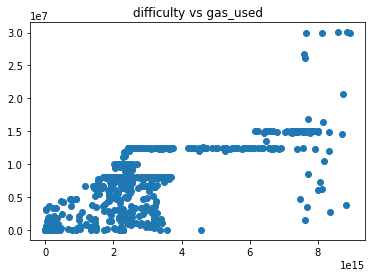

In [ ]:
plt.scatter(
    x=blocks['difficulty'], 
    y=blocks['gas_used']
)
plt.title("difficulty vs gas_used");

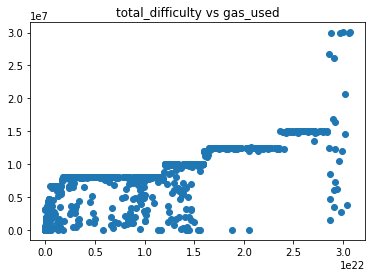

In [ ]:
plt.scatter(
    x=blocks['total_difficulty'], 
    y=blocks['gas_used']
)
plt.title("total_difficulty vs gas_used");

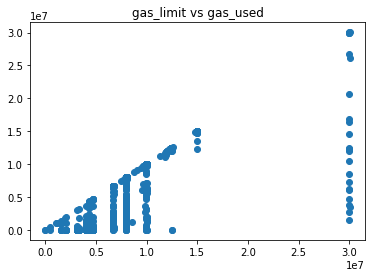

In [ ]:
plt.scatter(
    x=blocks['gas_limit'], 
    y=blocks['gas_used']
)
plt.title("gas_limit vs gas_used");

## Transactions

In [ ]:
transactions = data['transactions']

NameError: ignored

In [ ]:
def is_unique(col):
  try: 
    res = len(col) == len(col.unique())
  except TypeError:
    res = np.nan
  return res

In [ ]:
transactions_unique = {k : is_unique(transactions[k]) for k in transactions.columns}
transactions_unique

{'block_hash': True,
 'block_number': True,
 'block_timestamp': True,
 'from_address': False,
 'gas': False,
 'gas_price': False,
 'hash': True,
 'input': False,
 'max_fee_per_gas': False,
 'max_priority_fee_per_gas': False,
 'nonce': False,
 'receipt_contract_address': False,
 'receipt_cumulative_gas_used': False,
 'receipt_effective_gas_price': False,
 'receipt_gas_used': False,
 'receipt_root': False,
 'receipt_status': False,
 'to_address': False,
 'transaction_index': False,
 'transaction_type': False,
 'value': False}

In [ ]:
{
    k : transactions[k].value_counts(dropna=False) 
    for k, v in transactions_unique.items() if v == False and len(transactions[k].unique()) < 20
}

{'max_fee_per_gas': NaN             984
 1.690000e+11      1
 1.107543e+11      1
 5.994600e+10      1
 6.008379e+10      1
 1.250000e+11      1
 4.720000e+10      1
 5.540230e+10      1
 7.690661e+10      1
 1.393115e+11      1
 1.027598e+11      1
 1.727768e+11      1
 4.977828e+10      1
 1.315100e+11      1
 7.944059e+10      1
 8.709455e+10      1
 1.300000e+11      1
 Name: max_fee_per_gas, dtype: int64,
 'max_priority_fee_per_gas': NaN             984
 1.500000e+09      6
 1.000000e+09      2
 2.000000e+09      2
 7.000000e+09      1
 4.720000e+10      1
 4.000000e+09      1
 5.994600e+10      1
 1.940000e+09      1
 0.000000e+00      1
 Name: max_priority_fee_per_gas, dtype: int64,
 'receipt_contract_address': NaN                                           998
 0x2a4fa6c19cedaa211941c8381866f86c2f842190      1
 0x75d1011fde4bcdc6441ccbcead4037954e8dccb7      1
 Name: receipt_contract_address, dtype: int64,
 'receipt_status': 1.0    926
 NaN     49
 0.0     25
 Name: receipt_stat

In [ ]:
transactions[transactions['transaction_type'] == 2]['block_timestamp'].min()

Timestamp('2021-08-16 16:54:26+0000', tz='UTC')

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
receipt_contract_address,,,,,,,,,,,,,,,,,,,,,
False,2,2,2,2,0,2,2,2,2,2,2,2,0,2,2,2,2,0,0,0,2
True,998,998,998,998,998,998,998,998,998,998,998,0,49,949,998,998,998,16,16,16,998


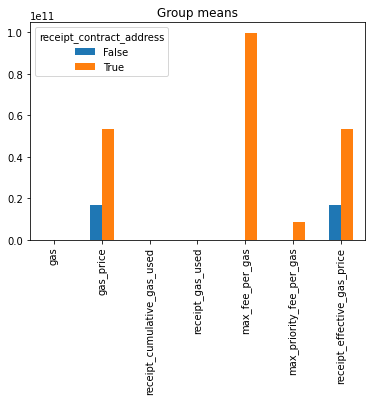

In [ ]:
contract_groups = transactions.groupby(
    transactions['receipt_contract_address'].isna()
    )

contract_groups.mean().filter(like='gas').transpose().plot.bar(
        title="Group means"
    );
contract_groups.count()
# need to normalize this by other factors

In [ ]:
### transactions on one day

In [ ]:
sample_addresses = transactions['from_address'][:100]
sample_addresses_str = "('" + "','".join(sample_addresses) + "')"
is_sc_sql = f"SELECT * FROM {tables['contracts']} " \
  f"WHERE address in {sample_addresses_str} LIMIT {limit}"

In [ ]:
### Join transactions with smart contracts
client.query(is_sc_sql).to_dataframe()

,address,bytecode,function_sighashes,is_erc20,is_erc721,block_timestamp,block_number,block_hash


## Contracts

In [ ]:
contracts = data["contracts"]

In [ ]:
for col in contracts.columns:
  print(col)

address
bytecode
function_sighashes
is_erc20
is_erc721
block_timestamp
block_number
block_hash


In [ ]:
{k : is_unique(contracts[k]) for k in contracts.columns}

{'address': True,
 'block_hash': False,
 'block_number': False,
 'block_timestamp': False,
 'bytecode': False,
 'function_sighashes': nan,
 'is_erc20': False,
 'is_erc721': False}

In [ ]:
contracts['bytecode']

0         0x6eb3f879cb30fe243b4dfee438691c043318585733ff
1      0x606060405236156100825760e060020a600035046306...
2      0x6080604052600080fd00a265627a7a723058204db7b4...
3      0x6060604052361561004a576000357c01000000000000...
4      0x60806040526004361061003b576000357c0100000000...
                             ...                        
995    0x608060405234801561001057600080fd5b5060043610...
996         0x6d4946c0e9f43f4dee607b0ef1fa1c3318585733ff
997    0x738018280076d7fa2caa1147e441352e8a89e1ddbe33...
998    0x7300000000a8f806c754549943b6550a2594c9a12633...
999    0x7300000000a8f806c754549943b6550a2594c9a12633...
Name: bytecode, Length: 1000, dtype: object

20


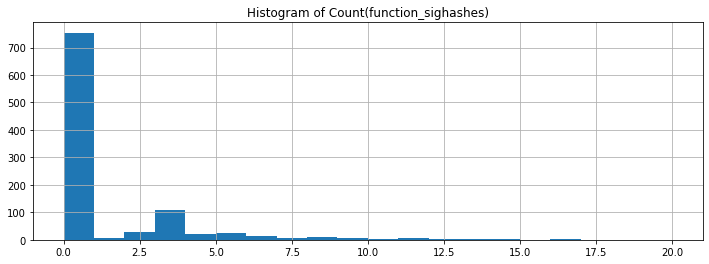

In [ ]:
# Question: Whar are function_sighashes?

num_functions = np.asarray([len(i) for i in contracts['function_sighashes']])
print(num_functions.max())
pd.Series(num_functions).hist(bins=20, figsize=(12, 4))
plt.title("Histogram of Count(function_sighashes)");

In [ ]:
# Question: Do smart contracts prompt transactions? 

## Logs

In [ ]:
logs = data["logs"]

In [ ]:
for col in logs.columns:
  print(col)

log_index
transaction_hash
transaction_index
address
data
topics
block_timestamp
block_number
block_hash


In [ ]:
{k : is_unique(logs[k]) for k in logs.columns}

{'address': False,
 'block_hash': True,
 'block_number': True,
 'block_timestamp': True,
 'data': False,
 'log_index': False,
 'topics': nan,
 'transaction_hash': True,
 'transaction_index': False}

In [ ]:
logs

,log_index,transaction_hash,transaction_index,address,data,topics,block_timestamp,block_number,block_hash
0,74,0x184d7c51d454828fc25105271d7884dd00ce14bcdd01...,53,0x98c6938f15cb8e12aff2a8ca9b0a9f2fc6e20901,0x00000000000000000000000000000000000000000000...,[0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78...,2020-07-14 20:57:15+00:00,10459901,0x4b3beb9ac6f63abee4dbfd67e61c1612a336e6167a15...
1,79,0xaa749c41096c4d0fd3b631d0205e86c7549f66090d1e...,1,0x8f7b0b40e27e357540f90f187d90ce06366ac5a5,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2018-06-28 11:45:14+00:00,5868910,0x826c204660fa2fa2fd82e134cb019bbe853a17b5a3a9...
2,197,0x9f17dc48dc49055e248206a14a00cdffbde901284a37...,168,0x8ab98c28295ea3bd2db6ac8b3ca57a625c054bd1,0xffffffffffffffffffffffffffffffffffffffffffff...,[0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...,2021-01-10 11:03:26+00:00,11626709,0x0aa1aef3bc5583bd40f584ab63e8ae880cbe5dac0af7...
3,757,0x4c150ba53e81d114d48bbd81b78a230ad9a2010885cb...,45,0xc92e74b131d7b1d46e60e07f3fae5d8877dd03f0,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2020-04-11 22:53:21+00:00,9853764,0xf8627b29bcdae23cb5ff19f251d501ce67de574c9919...
4,24,0x2250e21f118be5f5ca0232d42a0943f700efb215eec6...,23,0x34fa7ddde9d0e1b98cd281ee1e8ba1db37c64399,0x00000000000000000000000000000000000000000000...,[0x8b0128a4fabd37506205539bbe54f2446be33691844...,2019-08-17 11:29:50+00:00,8367705,0x9e4e275eee9b7757082620ec95c3cf2c84f6849ae14e...
...,...,...,...,...,...,...,...,...,...
995,67,0x5279d84592a5428dc86792be59a037d4b947bfad3ddd...,71,0x1e0447b19bb6ecfdae1e4ae1694b0c3659614e4e,0x00000000000000000000000000000000000000000000...,[0xf4626fd1187f91e6761ffb8a6ac3e8d9235a4a92da5...,2021-08-18 01:58:50+00:00,13046408,0x45674f415cac40c27f2600c3889fc1f2b67dd4f2315d...
996,246,0x8bb79574736570510a4dbad89aab82c9402dd8470b0b...,60,0x5a2c659fd2cbaa77c3fa30c062ca7cf7f9d60460,0x00000000000000000000000000000000000000000000...,[0x0f6798a560793a54c3bcfe86a93cde1e73087d944c0...,2018-03-24 03:42:39+00:00,5310903,0x527bbd4957a5ff0726794bc83310bff33926691aa4f7...
997,3,0x105b25f5b097005375eafeb691129a7a25ba6732da34...,2,0xf55c33d94150d93c2cfb833bcca30be388b14964,0x00000000000000000000000000000000000000000000...,[0xd78ad95fa46c994b6551d0da85fc275fe613ce37657...,2021-04-03 15:50:22+00:00,12167521,0xfad59978687c6e72cc8e5360bd60fc4cba4d2ab9e24e...
998,23,0xf3e0f09ed0ec024e26a83ea260bfa31ab1181fec14cf...,33,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2021-03-12 06:26:35+00:00,12022131,0x0b415023415b3f19ff96cc00d26607cb07fed90a9869...
